# Autoencoders: Detección de anomalías
# Práctica Electrocardiograma

Entrenar un autoencoder con los **ritmos normales** nos permitirá detectar anomalías. Así, una vez entrenado el modelo, puede usarse para reconstruir todos los datos (normales y anómalos).

La hipótesis que subyace en el trabajo es que los ritmos anormales van a tener un mayor **error de reconstrucción**. Así, sería clasificado un ritmo como una anomalía si el error de reconstrucción supera un umbral prefijado a partir de los datos de entrenamiento.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# semilla reproducción de datos
from numpy.random import seed
seed(222)

from tensorflow import random
random.set_seed(222)

ecg = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = ecg.values

ecg.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
# Resumen estadístico de las variables 
ecg.describe()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
count,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,...,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000,4998.000000
mean,-0.262502,-1.649828,-2.492623,-3.119754,-3.167656,-2.866306,-2.272845,-1.797754,-1.409784,-0.935806,...,0.071312,-0.062622,-0.276086,-0.507750,-0.761323,-0.835173,-0.642739,-0.487667,-0.706574,0.584034
std,1.152450,1.445542,1.386457,1.302921,1.104535,0.906312,0.731594,0.622794,0.636863,0.657788,...,1.404425,1.646105,1.894515,2.059366,2.086130,2.056296,1.859409,1.831088,1.414414,0.492937
min,-6.729499,-7.090374,-5.132459,-5.363241,-5.375715,-5.330194,-4.782240,-4.311288,-4.071361,-4.142476,...,-4.167040,-4.557576,-4.530488,-4.563270,-5.150100,-4.880460,-5.496107,-5.880890,-6.092227,0.000000
25%,-1.004220,-2.701936,-3.668585,-4.227337,-4.007630,-3.480666,-2.779832,-2.165808,-1.773870,-1.362003,...,-1.087720,-1.588237,-2.146835,-2.730750,-3.031224,-2.868603,-2.154560,-1.658289,-1.596809,0.000000
50%,-0.297541,-1.661892,-2.586129,-3.388210,-3.469899,-2.947061,-2.285427,-1.750084,-1.422457,-0.910384,...,0.658318,0.717808,0.604747,0.334857,-0.030767,-0.195151,-0.194423,-0.160262,-0.568443,1.000000
75%,0.499909,-0.677998,-1.514187,-2.235690,-2.531153,-2.398797,-1.823480,-1.484107,-1.063592,-0.476477,...,1.169392,1.238651,1.264379,1.234408,1.033957,0.945027,0.951621,1.002628,0.271635,1.000000
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.683730,1.898627,...,3.007606,2.854680,2.912394,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103,1.000000


Puede verse que el dataset está etiquetado (variable "140") de forma que el problema podría ser planteado como aprendizaje supervisado. Sin embargo, en este caso, se hará uso del diseño de un autoencoder para ilustrar conceptos de detección de anomalías.

In [3]:
ecg = ecg.rename(columns={140: 'target'})

print('Tamaño muestra (num)')
print(ecg['target'].value_counts())

print('Tamaño muestra (%)')
print(np.round(ecg['target'].value_counts(normalize=True),4)*100)

Tamaño muestra (num)
target
1.0    2919
0.0    2079
Name: count, dtype: int64
Tamaño muestra (%)
target
1.0    58.4
0.0    41.6
Name: proportion, dtype: float64


Destacar que, en este caso, los **ritmos normales** han sido etiquetados como **"1"**. 

Como en cualquier proceso de aprendizaje automático, se divide la muestra en entrenamiento (80%) y test (20%). Asimismo, se lleva a cabo una normalización de las variables predictoras.

In [4]:
# Partición de la muestra
train_data, test_data = train_test_split(ecg, test_size=0.2, random_state=123)

# Escalado de las variables
sc = MinMaxScaler().fit(train_data.drop(['target'], axis=1))
train_data_esc = sc.transform(train_data.drop(['target'], axis=1))
test_data_esc = sc.transform(test_data.drop(['target'], axis=1))

Se identifican los registros correspondientes con un electrocardiograma normal (el autoencoder se entrena solo con estos datos).

In [5]:
# identificación del target 
labels_train = train_data['target']
labels_test = test_data['target']

labels_train = labels_train.astype(bool)
labels_test = labels_test.astype(bool)

# Datos normales y anómalos
normal_train_data = train_data_esc[labels_train]
normal_test_data = test_data_esc[labels_test]

anomalous_train_data = train_data_esc[~labels_train]
anomalous_test_data = test_data_esc[~labels_test]

A modo comparativo, se grafican los electrocardiogramas (normal y anómalo).

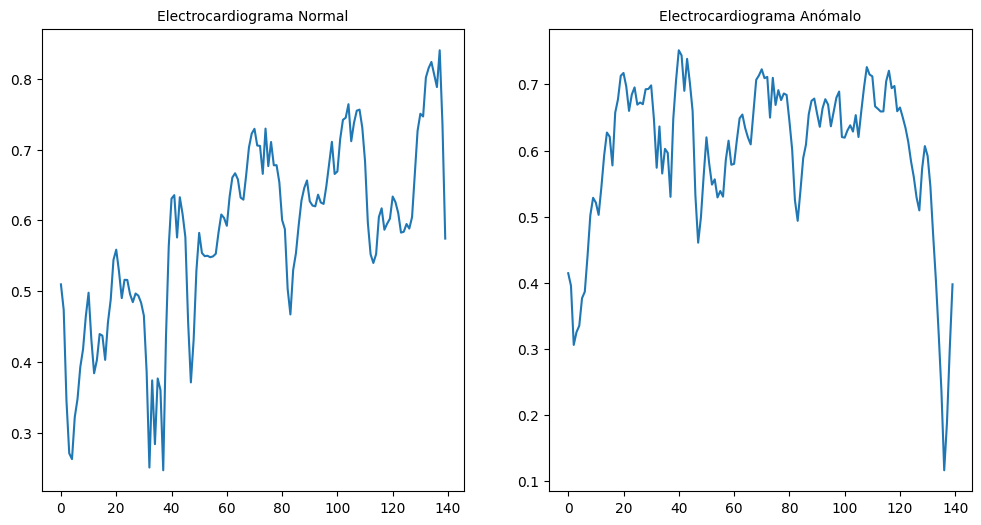

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot(np.arange(normal_train_data.shape[1]), normal_train_data[0])
ax2.plot(np.arange(anomalous_train_data.shape[1]), anomalous_train_data[0])
ax1.set_title('Electrocardiograma Normal', fontsize=10)
ax2.set_title('Electrocardiograma Anómalo', fontsize=10)

plt.show()

### Construcción del modelo

Se construye el autoencoder siguiendo el módulo *Funcional* de Tensorflow.

In [7]:
entrada = normal_train_data.shape[1]

# fase de comprensión de los datos
input_encoder = tf.keras.Input(shape=(entrada,)) # capa de entrada del autoencoder
enc1 = tf.keras.layers.Dense(units = 32, activation = "relu")(input_encoder)
encoder = tf.keras.layers.Dense(units = 8, activation = "relu")(enc1)

# modelo encoder
encoder_model = tf.keras.Model(inputs=input_encoder, outputs=encoder)

# fase decodificador de los datos
input_decoder = tf.keras.Input(shape=(8,))
dec1= tf.keras.layers.Dense(units = 32, activation = "relu")(input_decoder)
decoder = tf.keras.layers.Dense(units = entrada, activation = "sigmoid")(dec1)

decoder_model = tf.keras.Model(inputs = input_decoder, outputs = decoder)

# Modelo autoencoder
encoder_decoder = input_encoder 
encoder_decoder = encoder_model(encoder_decoder)
encoder_decoder = decoder_model(encoder_decoder)
                  
autoencoder = tf.keras.Model(inputs = input_encoder, outputs = encoder_decoder)


# Nota: otra forma de construir el autoencoder (apilamiento de capas)
# recordar que siguiendo la API funcional un modelo se obtiene mediante la unión de capas

# inputs = tf.keras.Input(shape=(entrada,))
# hidden1 = tf.keras.layers.Dense(32, activation="relu")(inputs)
# hidden2 = tf.keras.layers.Dense(8, activation="relu")(hidden1)
# hidden3 = tf.keras.layers.Dense(32, activation="relu")(hidden2)
# capas_encoder_decoder = tf.keras.layers.Dense(entrada, activation="sigmoid")(hidden3)
    
# autoencoder2 = tf.keras.Model(inputs=inputs, outputs=capas_encoder_decoder)

Se presenta un resumen de las capas, neuronas y parámetros del modelo creado.

In [8]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 8)                   │           4,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_3 (Functional)            │ (None, 140)                 │           4,908 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,684 (37.83 KB)

 Trainable params: 9,684 (37.83 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, se compila y se procede a entrenar el modelo.

In [9]:
autoencoder.compile(optimizer='adam', loss='mae')

hist = autoencoder.fit(normal_train_data,
              normal_train_data,
              epochs=50,
              validation_split=0.2,
              batch_size=128,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1338 - val_loss: 0.1199
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1111 - val_loss: 0.0879
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0809 - val_loss: 0.0663
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0618 - val_loss: 0.0548
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0520 - val_loss: 0.0502
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.0485
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - val_loss: 0.0474
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - val_loss: 0.0462
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0445 - val_loss: 0.0444
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0429 - val_loss: 0.0424
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0410 - val_loss: 0.0406
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0396 - val_lo

Se muestra el resumen de la bondad de ajuste en el entrenamiento del modelo:

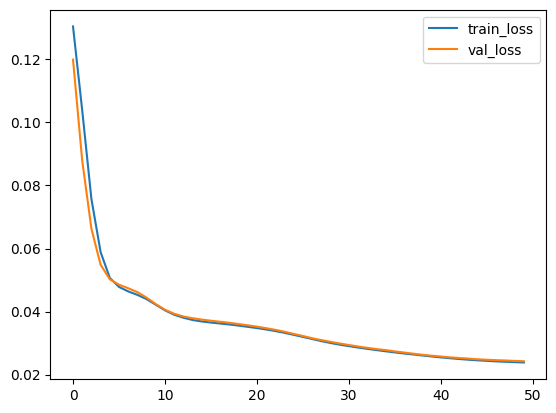

In [10]:
# construcción de un data.frame
df_train=pd.DataFrame(hist.history)
df_train['epochs']=hist.epoch

plt.plot(df_train['epochs'], df_train['loss'], label='train_loss')
plt.plot(df_train['epochs'], df_train['val_loss'], label='val_loss')

plt.legend(loc="upper right")
plt.show()

Se reconstruyen los datos de entrenamiento y se calcula su error en la reconstrucción

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


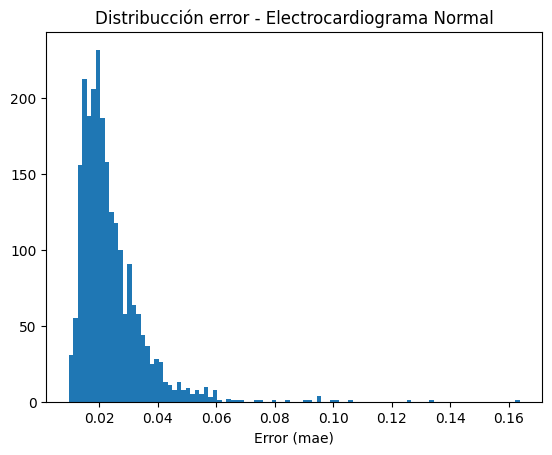

In [11]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(np.array(train_loss), bins=100)
plt.title('Distribucción error - Electrocardiograma Normal')
plt.xlabel('Error (mae)')
plt.show()

En base a la distribución de pérdidas, se establece un umbral para el cual los electrocardiogramas de los pacientes deberían ser revisados.

In [12]:
# uso de la mediana porque la distribución no es simétrica
umbral = np.round(np.median(train_loss) + 2*np.std(train_loss),5)
print('Umbral:', umbral)

Umbral: 0.04377


Se aplica el modelo a la muestra de test. Reconstrucción de los datos y cálculo del error:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


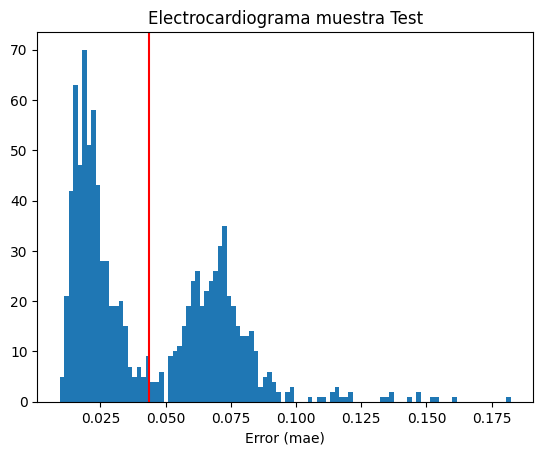

In [13]:
reconstructions = autoencoder.predict(test_data_esc)
test_loss = tf.keras.losses.mae(reconstructions, test_data_esc)

plt.hist(np.array(test_loss), bins=100)
plt.axvline(x=umbral, color='red')
plt.title('Electrocardiograma muestra Test')
plt.xlabel('Error (mae)')
plt.show()

Así, a partir del error de reconstrucción observamos que existen muchos cardigoramas con un error entre 0.075-0.1

Por último, mostramos la bondad de nuestro modelo mediante diferentes métricas:
- Accuracy, precision, recall
- Matriz de confusión

In [14]:
# Funciones bondad de ajuste

def predict(model, data, umbral):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return np.array(tf.math.less(loss, umbral))

def print_sol(preds, labels):
  print("Accuracy = {}".format(np.round(accuracy_score(labels, preds),3)))
  print("Precision = {}".format(np.round(precision_score(labels, preds),3)))
  print("Recall = {}".format(np.round(recall_score(labels, preds),3)))

Accuracy = 0.956
Precision = 0.993
Recall = 0.933


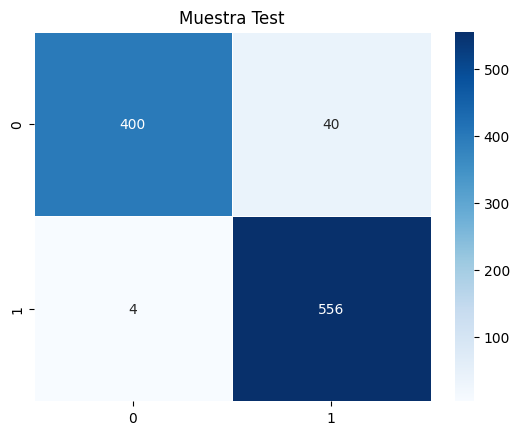

In [15]:
# Métricas (accuracy, precision, recall)
preds = predict(autoencoder, test_data_esc, umbral)
print_sol(preds, labels_test)

# matriz de confusión
sns.heatmap(confusion_matrix(preds, labels_test), cmap="Blues", linewidths=.5, 
            annot = True,  fmt='.0f', cbar=True)
plt.title('Muestra Test')
plt.show()